<a href="https://colab.research.google.com/github/silver5938/NLP_Twitter_Sentiment/blob/main/NLP_Twitter_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**" 딥러닝을 이용한 트위터 감성 분석 project "**

1. 학습 데이터 : AI허브에서 가져온 감성 train 데이터를 사용
2. 테스트 데이터 : lucy api를 이용해 데이터 10,000건 추출

프로젝트 세팅

In [ ]:
# DATASET
DATASET_COLUMNS = ["seq", "age", "sex", "keywords","health", "sentiment1", "sentiment2","text"]
DATASET_ENCODING = "CP949"
TRAIN_SIZE = 40879

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+" #http주소 제거

# WORD2VEC 
W2V_SIZE = 100 #워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
W2V_WINDOW = 5 #컨텍스트 윈도우 크기
W2V_EPOCH = 3 #학습을 위한 프로세스 수
W2V_MIN_COUNT = 3 #단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)


# SENTIMENT
기쁨 = "기쁨"
당황 = "당황"
불안 = "불안"
분노 = "분노"
슬픔 = "슬픔"
상처 =  "상처"


# EXPORT
SENTIMENT_MODEL = "LSTM 이용" #감성 예측 모델
WORD2VEC_MODEL = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=W2V_EPOCH)
TOKENIZER_MODEL = "Tokenizer() 이용" #토크나이징
ENCODER_MODEL = "LabelEncoder() 이용" #문자를 수치화

기타 설정(import)


In [1]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch

In [2]:
#깃허브에서 KoBERT 파일 로드
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-gywov3zz
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-gywov3zz


In [3]:
#pytorch
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
from tqdm import tqdm, tqdm_notebook

#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

#GPU 사용
device = torch.device("cuda:0")

#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

# DataFrame
import pandas as pd

# Matplot
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm  # 폰트 관련 용도
import seaborn as sns
import missingno as msno
from plotly import graph_objs as go
plt.style.use('seaborn')
sns.set(font_scale=2.5) # matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편함

%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

using cached model
using cached model


※ 한글 깨짐 현상을 해결하는 방법 ※

In [3]:
# Google Colab matplotlib 한글 폰트 오류 문제 해결

# 1. 나눔 폰트 다운
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 2. 런타임 다시 시작



Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [4]:
# 3. matplotlib의 폰트를 Nanum 폰트로 지정
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

파일 업로드 - drive연동했다면 할 필요 없음

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
from google.colab import files
uploaded = files.upload()

파일 불러오기 :  
한글은 utf-8형식이므로 깨지기 때문에 encoding='CP949' 로 설정 해 주어야 한다.

In [ ]:
# colab과 google Drive 연동을 위한 인증 및 네트워크 디렉토리 마운트
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/dataset/s_training.CSV', encoding='CP949')
df_test = pd.read_csv('/content/drive/MyDrive/dataset/s_test.CSV', encoding='CP949')

head 메소드를 이용해 데이터 확인

In [7]:
df_test.head(5)

,i_docid,i_sitename,i_url,i_title,i_sdate,sentiment1
0,TW1419668235989880833,Twitter,https://twitter.com/KaiS2com/status/1419668235...,＂걱정돼서 전화했어요＂ 우도주막 걱정에 깜짝 전화한 에이스 카이ㅜㅜ(서윗) | tv...,20210726,기쁨
1,TW1419661732599844866,Twitter,https://twitter.com/HuffPostKorea/status/14196...,"""돈에 지배당한 것"" 서장훈이 쓰리잡으로 1억 모은 25살 의뢰인에게 한 말은 일리...",20210726,기쁨
2,TW1419672897426231297,Twitter,https://twitter.com/threadreaderapp/status/141...,"@aqualemine Namaste, please find the unroll he...",20210726,기쁨
3,TW1419667990836957184,Twitter,https://twitter.com/Angry82pigeon/status/14196...,@dullchip0 너무 좋은..생각이예요 모두 궁금한걸~?!?(슴췹님 그림 하나라...,20210726,기쁨
4,TW1419672897426231297,Twitter,https://twitter.com/threadreaderapp/status/141...,"@aqualemine Namaste, please find the unroll he...",20210726,기쁨


In [8]:
df_train.head(5)

,seq,age,sex,keywords,health,sentiment1,sentiment2,text
0,2,청년,남성,"진로, 취업, 직장",해당없음,불안,두려운,회사에서 중요한 큰 프로젝트를 나 혼자 하게 되니 솔직히 두려워.
1,3,청년,남성,"진로, 취업, 직장",해당없음,불안,두려운,회사에 직장 상사가 무섭게 생겨서 친해지는 게 두려워.
2,4,청년,남성,"진로, 취업, 직장",해당없음,불안,두려운,이번에 처음으로 힘들게 들어간 직장인데 첫 직장이라서 그런지 너무 긴장돼.
3,5,청년,남성,"진로, 취업, 직장",해당없음,불안,두려운,직장에서 사람들과의 관계에서 안 좋아질까 걱정돼.
4,7,청년,남성,"진로, 취업, 직장",해당없음,불안,두려운,회의 시간에 나의 직급이 낮아서 그런지 의견을 무시하는 경향이 있어서 의견을 제시하...


데이터 갯수 확인

In [9]:
train_len = len(df_train)
test_len = len(df_test)

In [10]:
train_len

40879

In [11]:
test_len

303

info 메소드 이용해 기본적인 데이터 정보 확인

In [12]:
df_train.info()
df_train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40879 entries, 0 to 40878
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   seq         40879 non-null  int64 
 1   age         40879 non-null  object
 2   sex         40879 non-null  object
 3   keywords    40879 non-null  object
 4   health      40879 non-null  object
 5   sentiment1  40879 non-null  object
 6   sentiment2  40879 non-null  object
 7   text        40879 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.5+ MB


seq           0
age           0
sex           0
keywords      0
health        0
sentiment1    0
sentiment2    0
text          0
dtype: int64

In [13]:
df_test.info()
df_test.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   i_docid     303 non-null    object
 1   i_sitename  303 non-null    object
 2   i_url       303 non-null    object
 3   i_title     303 non-null    object
 4   i_sdate     303 non-null    int64 
 5   sentiment1  303 non-null    object
dtypes: int64(1), object(5)
memory usage: 14.3+ KB


i_docid       0
i_sitename    0
i_url         0
i_title       0
i_sdate       0
sentiment1    0
dtype: int64


데이터 null값 확인(1)

In [14]:
for col in df_train.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msg)

column:        seq	 Percent of NaN value: 0.00%
column:        age	 Percent of NaN value: 0.00%
column:        sex	 Percent of NaN value: 0.00%
column:   keywords	 Percent of NaN value: 0.00%
column:     health	 Percent of NaN value: 0.00%
column: sentiment1	 Percent of NaN value: 0.00%
column: sentiment2	 Percent of NaN value: 0.00%
column:       text	 Percent of NaN value: 0.00%


In [15]:
for col in df_test.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msg)

column:    i_docid	 Percent of NaN value: 0.00%
column: i_sitename	 Percent of NaN value: 0.00%
column:      i_url	 Percent of NaN value: 0.00%
column:    i_title	 Percent of NaN value: 0.00%
column:    i_sdate	 Percent of NaN value: 0.00%
column: sentiment1	 Percent of NaN value: 0.00%


데이터 null값 확인(2) - 그래프

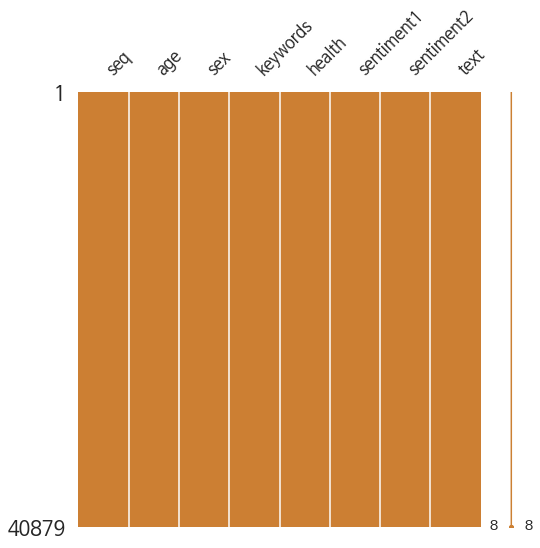

In [16]:
msno.matrix(df=df_train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

2021-07-28 03:39:26,120 : INFO : NumExpr defaulting to 2 threads.


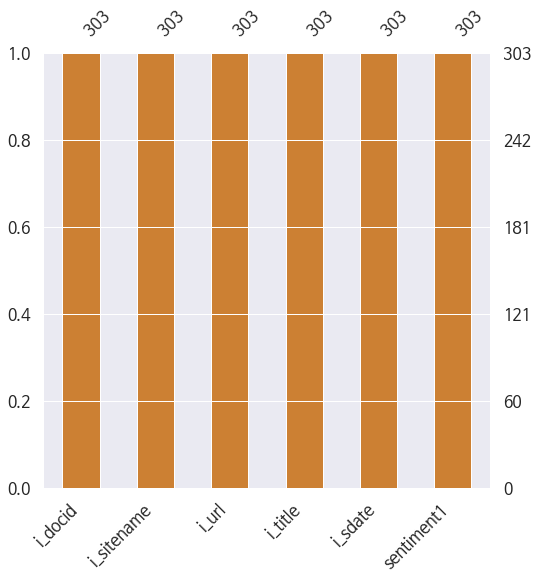

In [17]:
msno.bar(df=df_test.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

데이터 확인하기 - 감정 별 분류

데이터 정제(Data Cleaning)_1

In [18]:
df_train.drop_duplicates(subset = ['text'], inplace=True) # text 열에서 중복인 내용이 있다면 중복 제거
df_train['text'] = df_train['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
df_train['text'] = df_train['text'].str.replace('^ +', "") # 공백은 empty 값으로 변경
df_train['text'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
df_train = df_train.dropna(how='any') # Null 값 제거
print('전처리 후 학습용 샘플의 개수 :',len(df_train))

전처리 후 학습용 샘플의 개수 : 39415


In [19]:
df_test.drop_duplicates(subset = ['i_title'], inplace=True) # i_title 열에서 중복인 내용이 있다면 중복 제거
df_test['i_title'] = df_test['i_title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
df_test['i_title'] = df_test['i_title'].str.replace('^ +', "") # 공백은 empty 값으로 변경
df_test['i_title'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
df_test = df_test.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(df_test))

전처리 후 테스트용 샘플의 개수 : 297


In [20]:
df_train.sample(n=10)

,seq,age,sex,keywords,health,sentiment1,sentiment2,text
9191,11559,노년,여성,재정,만성질환 유,기쁨,신이 난,십 년 전에 투자한 주식이 많이 올라 너무 좋아
7947,9964,노년,여성,재정,만성질환 유,슬픔,후회되는,미리미리 주식 좀 사두거나 적금 좀 제대로 들어둘 걸 그랬나 봐
20275,25578,청소년,여성,학업 및 진로,해당없음,슬픔,눈물이 나는,나 오늘 선생님과 대학 입시 상담을 했어 나의 모자람에 눈물이 나더라
24100,30328,중년,여성,"대인관계(부부, 자녀)",해당없음,기쁨,흥분,아들이 명절 때 집에 온다고 해서 오늘은 하루 종일 기분이 좋아
16784,21136,중년,여성,"대인관계(부부, 자녀)",해당없음,슬픔,우울한,사춘기인 딸이 나만 보면 짜증을 내고 말도 못 걸게 하네
28016,35239,중년,여성,건강,해당없음,기쁨,기쁨,오 년 동안 날 괴롭게 하던 허리통증이 오늘 마침내 다 나았다
36515,45922,청소년,남성,학교폭력/따돌림,해당없음,상처,고립된,학교 다니기 너무 외로워
23767,29928,중년,여성,건강,해당없음,상처,충격 받은,자식들에게 빈말로라도 건강하게 오래 살라는 말을 들어본 기억이 없어 생각할수록 섭섭해
15978,20111,청년,여성,"연애, 결혼, 출산",해당없음,기쁨,기쁨,얼마 전에 가장 친한 친구가 첫 출산을 했는데 내가 울었어
8912,11208,청소년,여성,학교폭력/따돌림,해당없음,상처,"가난한, 불우한",내가 애들을 괴롭히는 이유는 다 우리 집이 가난해서야


In [21]:
df_test.sample(n=10)

,i_docid,i_sitename,i_url,i_title,i_sdate,sentiment1
106,TW1419653891684110341,Twitter,https://twitter.com/3040lys/status/14196538916...,불행해지는 방법 나태하기 가까운 사람에게 소홀하기 자신의 몸과 마음에 무관심하기 남...,20210726,슬픔
154,TW1419648699374833668,Twitter,https://twitter.com/hanitweet/status/141964869...,현지에 눈이 잠깐 녹은 사이 풍화된 시신이 발견된 것이다 시신과 함께 발견된 연세대...,20210726,당황
105,TW1419654990218604544,Twitter,https://twitter.com/CJnDrama/status/1419654990...,티격태격 위기의 도다커플도다 애정전선 이대로 괜찮은 것인가 월화 밤 시 너는나의봄 ...,20210726,불안
202,TW1419643671939469326,Twitter,https://twitter.com/yonhaptweet/status/1419643...,배우 김민귀 측 사생활 물의 사과자가격리 위반은 부인배우 김민귀 측이 최근 온라인 ...,20210726,슬픔
58,TW1419666316567486466,Twitter,https://twitter.com/yonhaptweet/status/1419666...,미국서 모래폭풍으로 고속도로 중 추돌최소 명 사망미국 유타주의 한 고속도로에서 강한...,20210726,상처
230,TW1419639983032266762,Twitter,https://twitter.com/wikitree/status/1419639983...,안타까운 소식입니다 용감한형제 용감한형제부친상 브레이브걸스소속사대표,20210726,슬픔
172,TW1419646860013223941,Twitter,https://twitter.com/zchwine/status/14196468600...,천러 우리 음악 스타 천러 천러,20210726,기쁨
167,TW1419647031338012672,Twitter,https://twitter.com/zchwine/status/14196470313...,우리는 항상 천러을 지원할 것입니다 천러 천러,20210726,기쁨
127,TW1419651430357422083,Twitter,https://twitter.com/1004COREA/status/141965143...,사랑에 빠진 여자가 아름다운 이유는 새 화장품과 원피스 때문이 아니다그대로의 모습을...,20210726,기쁨
55,TW1419658982604501001,Twitter,https://twitter.com/hankookilbo/status/1419658...,윤 총장은 최근 야권이 분열하면 대선은 필패라고 했다 하지만 후보 단일화를 해도 올...,20210726,불안


데이터 확인

In [26]:
filteredData = df_train['sentiment1'].isin(['기쁨','분노','불안','슬픔','상처','당황'])
filterdd = df_train[~filteredData]

In [28]:
temp = df_train.groupby('sentiment1').count()['seq'].reset_index().sort_values(by='seq',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment1,seq
0,0,7107
2,2,6671
1,1,6659
3,3,6455
4,4,6421
5,5,6102


In [29]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment1,
    values = temp.seq,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

감성(sentiment1) 라벨링

In [22]:
df_train.loc[(df_train['sentiment1'] == "불안"), 'sentiment1'] = 0  #불안 => 0
df_train.loc[(df_train['sentiment1'] == "슬픔"), 'sentiment1'] = 1  #슬픔 => 1
df_train.loc[(df_train['sentiment1'] == "분노"), 'sentiment1'] = 2  #분노 => 2
df_train.loc[(df_train['sentiment1'] == "기쁨"), 'sentiment1'] = 3  #기쁨 => 3
df_train.loc[(df_train['sentiment1'] == "상처"), 'sentiment1'] = 4  #상처 => 4
df_train.loc[(df_train['sentiment1'] == "당황"), 'sentiment1'] = 5  #당황 => 5

In [23]:
data_list = []
for q, label in zip(df_train['text'], df_train['sentiment1'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [24]:
print(data_list[0])
print(data_list[6000])
print(data_list[12000])
print(data_list[18000])
print(data_list[24000])
print(data_list[30000])
print(data_list[-1])

['회사에서 중요한 큰 프로젝트를 나 혼자 하게 되니 솔직히 두려워', '0']
['내가 육십 세부터 받을 수 있는 연금 금액이 실망스러워 ', '1']
['내가 업무 때문에 직장동료에게 전화를 했는데 글쎄 직장동료 애인이 나를 내연녀로 오해했대', '5']
['결혼한 지 오 년째 아이가 생기지 않아서 눈물이 나', '1']
['새로운 부서에 발령을 받았는데 명예퇴직 대상자만 모아둔 곳이라 우울해', '1']
['모든 가족의 빚을 나 혼자 갚고 있어서 고립된 느낌이야 아무도 나를 도와주지 않아', '4']
['나 매우 화가 나', '2']


In [27]:
filterdd

,seq,age,sex,keywords,health,sentiment1,sentiment2,text
0,2,청년,남성,"진로, 취업, 직장",해당없음,0,두려운,회사에서 중요한 큰 프로젝트를 나 혼자 하게 되니 솔직히 두려워
1,3,청년,남성,"진로, 취업, 직장",해당없음,0,두려운,회사에 직장 상사가 무섭게 생겨서 친해지는 게 두려워
2,4,청년,남성,"진로, 취업, 직장",해당없음,0,두려운,이번에 처음으로 힘들게 들어간 직장인데 첫 직장이라서 그런지 너무 긴장돼
3,5,청년,남성,"진로, 취업, 직장",해당없음,0,두려운,직장에서 사람들과의 관계에서 안 좋아질까 걱정돼
4,7,청년,남성,"진로, 취업, 직장",해당없음,0,두려운,회의 시간에 나의 직급이 낮아서 그런지 의견을 무시하는 경향이 있어서 의견을 제시하...
...,...,...,...,...,...,...,...,...
40873,51420,청소년,여성,학교폭력/따돌림,해당없음,5,외로운,요즘 학교에서 왕따 당해서 너무 외로워
40874,51421,노년,남성,대인관계,만성질환 유,5,외로운,요즘 질병도 있고 병도 걸려서 사는게 너무 외로워
40875,51422,노년,여성,"건강, 죽음",만성질환 무,5,외로운,최근 죽음에 대해 생각하다보니 너무 외로워
40876,51423,중년,남성,"직장, 업무 스트레스",해당없음,5,외로운,환갑이 가까워오니 직장내에서 너무 외로워


데이터 정제(Data Cleaning)_2

In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

In [29]:
from konlpy.tag import Mecab
mecab = Mecab()

In [30]:
#불용어 제거
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


In [31]:
X_train = []
for sentence in df_train['text']:
    temp_X = mecab.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [ ]:
X_train[:10]

sklearn을 이용한 Train & Test 데이터 나누기

In [30]:
#train & test 데이터로 나누기
                                                     
dataset_train, dataset_test = train_test_split(data_list, test_size=0.20, random_state=0)

In [31]:
print(len(dataset_train))
print(len(dataset_test))

31532
7883


KoBERT 입력 데이터로 만들기

데이터를 train data와 test data로 나누었다면 각 데이터가 KoBERT 모델의 입력으로 들어갈 수 있는 형태가 되도록 토큰화, 정수 인코딩, 패딩 등을 해주어야 한다. 예시 코드에 입력데이터의 형태가 되도록 해주는 클래스가 있어서 동일하게 코드를 작성해주었다.

In [32]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

하이퍼 파라미터들을 조정해준다. Batch size는 64, epochs는 8, learning rate는 5e-5로 설정

In [40]:
# Setting parameters
max_len = 200
batch_size = 32
warmup_ratio = 0.1
num_epochs = 6
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

토크나이징(tokenizing)

In [41]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model


In [42]:
data_train[0]

(array([   2, 4626, 7828, 4628, 7086, 2047, 5156, 6896, 4598, 7342, 7880,
        1375, 3129, 5859, 3166, 6273, 6542, 7096, 6844,    3,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1, 

torch형식의 dataset 만들기

In [43]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

KoBERT 학습모델 만들기

In [44]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=6,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [45]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

KoBERT 모델 학습시키기

In [46]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

epoch 1 batch id 1 loss 1.8331575393676758 train acc 0.09375
epoch 1 batch id 201 loss 0.7448927760124207 train acc 0.5481965174129353
epoch 1 batch id 401 loss 0.7203896641731262 train acc 0.6759663341645885
epoch 1 batch id 601 loss 0.525244414806366 train acc 0.7130823627287853
epoch 1 batch id 801 loss 0.6722173690795898 train acc 0.7270989388264669

epoch 1 train acc 0.7321881338742393



epoch 1 test acc 0.6115200588884799


epoch 2 batch id 1 loss 0.6958646774291992 train acc 0.78125
epoch 2 batch id 201 loss 0.6045649647712708 train acc 0.7646144278606966
epoch 2 batch id 401 loss 0.7012034058570862 train acc 0.7753273067331671
epoch 2 batch id 601 loss 0.45963621139526367 train acc 0.7829138935108153
epoch 2 batch id 801 loss 0.7045217156410217 train acc 0.7869460049937578

epoch 2 train acc 0.7876838235294118



epoch 2 test acc 0.6132683106367317


epoch 3 batch id 1 loss 0.7406570911407471 train acc 0.71875
epoch 3 batch id 201 loss 0.45654696226119995 train acc 0.8064365671641791
epoch 3 batch id 401 loss 0.4922107756137848 train acc 0.8107076059850374
epoch 3 batch id 601 loss 0.3283234238624573 train acc 0.8160877703826955
epoch 3 batch id 801 loss 0.3871039152145386 train acc 0.8204588014981273

epoch 3 train acc 0.8238463488843814



epoch 3 test acc 0.6116350754508649


epoch 4 batch id 1 loss 0.5462257862091064 train acc 0.78125
epoch 4 batch id 201 loss 0.33922770619392395 train acc 0.8345771144278606
epoch 4 batch id 401 loss 0.5568695068359375 train acc 0.8458541147132169
epoch 4 batch id 601 loss 0.21499103307724 train acc 0.8529014143094842
epoch 4 batch id 801 loss 0.15446408092975616 train acc 0.8574828339575531

epoch 4 train acc 0.8596285496957403



epoch 4 test acc 0.6061947920500552


epoch 5 batch id 1 loss 0.3820623755455017 train acc 0.9375
epoch 5 batch id 201 loss 0.3124949336051941 train acc 0.8745335820895522
epoch 5 batch id 401 loss 0.34199967980384827 train acc 0.8811564837905237
epoch 5 batch id 601 loss 0.2524600327014923 train acc 0.8874792013311148
epoch 5 batch id 801 loss 0.12468867003917694 train acc 0.8923220973782772

epoch 5 train acc 0.8942380831643002



epoch 5 test acc 0.6127622377622377


epoch 6 batch id 1 loss 0.24014243483543396 train acc 0.9375
epoch 6 batch id 201 loss 0.47370558977127075 train acc 0.9085820895522388
epoch 6 batch id 401 loss 0.26934707164764404 train acc 0.912718204488778
epoch 6 batch id 601 loss 0.12407591193914413 train acc 0.9169093178036606
epoch 6 batch id 801 loss 0.039600715041160583 train acc 0.9196317103620475

epoch 6 train acc 0.9210509634888439



epoch 6 test acc 0.6089666912035333


epoch 7 batch id 1 loss 0.29392966628074646 train acc 0.875
epoch 7 batch id 201 loss 0.2819882333278656 train acc 0.9287935323383084
epoch 7 batch id 401 loss 0.2806212604045868 train acc 0.931966957605985
epoch 7 batch id 601 loss 0.08378374576568604 train acc 0.9347441763727121
epoch 7 batch id 801 loss 0.04367394000291824 train acc 0.935666354556804

epoch 7 train acc 0.9360737829614605



epoch 7 test acc 0.6040324806772175


epoch 8 batch id 1 loss 0.48937803506851196 train acc 0.84375
epoch 8 batch id 201 loss 0.21769213676452637 train acc 0.9348569651741293
epoch 8 batch id 401 loss 0.22842377424240112 train acc 0.940928927680798
epoch 8 batch id 601 loss 0.18521597981452942 train acc 0.9431156405990017
epoch 8 batch id 801 loss 0.08702538162469864 train acc 0.9444054307116105

epoch 8 train acc 0.945106490872211



epoch 8 test acc 0.6058037357379462


예측 모델(문장 테스트)


In [ ]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model1.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model1(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("불안")
            elif np.argmax(logits) == 1:
                test_eval.append("슬픔")
            elif np.argmax(logits) == 2:
                test_eval.append("분노")
            elif np.argmax(logits) == 3:
                test_eval.append("기분")
            elif np.argmax(logits) == 4:
                test_eval.append("상처")
            elif np.argmax(logits) == 5:
                test_eval.append("당황")
            else 
                test_eval.append("중립")

        print(">> 입력한 내용의 감성은 " + test_eval[0] + " 입니다.")